<a href="https://colab.research.google.com/github/JingwenLuo7/MLAILS-2025/blob/main/Project_01/ANNSigSig_MTBLS136.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> ANNSigSig_MTBLS136 </h1>

<br>
<br>
<br>
<p style="text-align: justify"> The study used in this tutorial has been previously published by  <a href="https://europepmc.org/abstract/MED/30830410">Stevens et al. (2018)</a>, and the deconvolved and annotated data file deposited at the Metabolights data repository. The data can be accessed directly via its study ID: <a href="https://www.ebi.ac.uk/metabolights/MTBLS136">MTBLS136</a>. This workflow requires data to be formatted as a Microsoft Excel file, using the Tidy Data framework (i.e. each column is a variable, and row is an observation). As such, the Excel file contains a Data Sheet and Peak Sheet. The Data Sheet contains all the metabolite concentrations and metadata associated with each observation (requiring the inclusion of the columns: Idx, SampleID, and Class). The Peak Sheet contains all the metadata pertaining to each measured metabolite (requiring the inclusion of the columns: Idx, Name, and Label). Please inspect the Excel file <a href="https://github.com/CIMCB/MetabComparisonBinaryML/blob/master/dynamic/data/MTBLS136.xlsx?raw=true">MTBLS136.xlsx</a> used in this workflow before proceeding.</p>

<p style="text-align: justify">This is a serum LC-MS dataset consisting of 949 named metabolites. The primary outcome for this paper was estrogen-only (E; n=332) vs. estrogen plus progestin (E+P; n=337) vs. non-users of post-menopausal hormone therapy regimes (Control; n=667). For the purpose of this study, we compare only the E vs. E+P in a binary discriminant analysis.</p>
<br>


</ol>
</div>

### 1. Import Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split,KFold
from sklearn.metrics import (
    r2_score,
    accuracy_score,roc_auc_score,
    classification_report,
    roc_curve,auc
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import SGD

print('All packages successfully loaded')

All packages successfully loaded


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Load Data & Peak Sheet

In [ ]:
#home = 'data/'
home = '/content/drive/MyDrive/'
file = 'MTBLS136.xlsx'

#DataTable,PeakTable = cb.utils.load_dataXL(home + file, DataSheet='Data', PeakSheet='Peak')
DataTable = pd.read_excel(home + file, sheet_name='Data')
PeakTable = pd.read_excel(home + file, sheet_name='Peak')

### 3. Extract X & Y

In [ ]:
# Clean PeakTable and Extract PeakList
PercMiss = PeakTable['Perc_missing']
PeakTableClean = PeakTable[(PercMiss < 20)]
PeakList = PeakTableClean['Name']

# Select Subset of Data
DataTable2 = DataTable[(DataTable.Class == 1) | (DataTable.Class == 0)]

# Create a Binary Y Vector
Outcomes = DataTable2['Class']
Y = Outcomes.values

# Split Data into Train (2/3) and Test (1/3)
DataTrain, DataTest, YTrain, YTest = train_test_split(DataTable2, Y, test_size=1/3, stratify=Y, random_state=85)

# Extract Train Data
XTrain = DataTrain[PeakList]
XTrainLog = np.log(XTrain)

# Calculate mu and sigma from Train Data
mu = np.nanmean(XTrainLog, axis=0)  # Calculate mean of each column, ignoring NaNs
sigma = np.nanstd(XTrainLog, axis=0) # Calculate standard deviation of each column, ignoring NaNs

# Fill missing values in Test Data using mu and sigma from Train Data
XTest = DataTest[PeakList]
XTestLog = np.log(XTest)
XTestLog = XTestLog.fillna(pd.DataFrame(mu).T)  # Fill NaNs with mu
# XTestLog = XTestLog.fillna(pd.DataFrame(mu).T)  # Fill NaNs with sigma - This would not be usually done


# Scale Train Data
scaler = StandardScaler()
XTrainScale = scaler.fit_transform(XTrainLog)

# Impute Train Data
imputer = KNNImputer(n_neighbors=3)  # k=3
XTrainKnn = imputer.fit_transform(XTrainScale)


# Scale Test Data (using mu and sigma from Train Data)
XTestScale = scaler.transform(XTestLog)  # Use the same scaler fitted on training data

# Impute Test Data
XTestKnn = imputer.transform(XTestScale)  # Use the same imputer fitted on training data



### 4. Hyperparameter Optimisation

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.8836  
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.8016
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.7433
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7109  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7171  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7200  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7115  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7209  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7954  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7690  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7034  
3/3 ━━

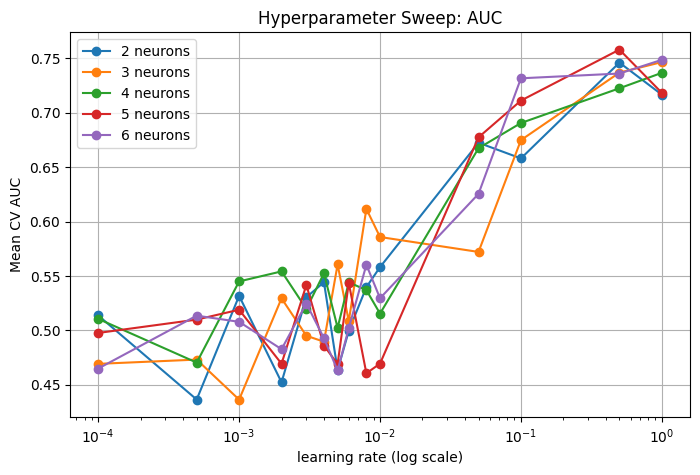

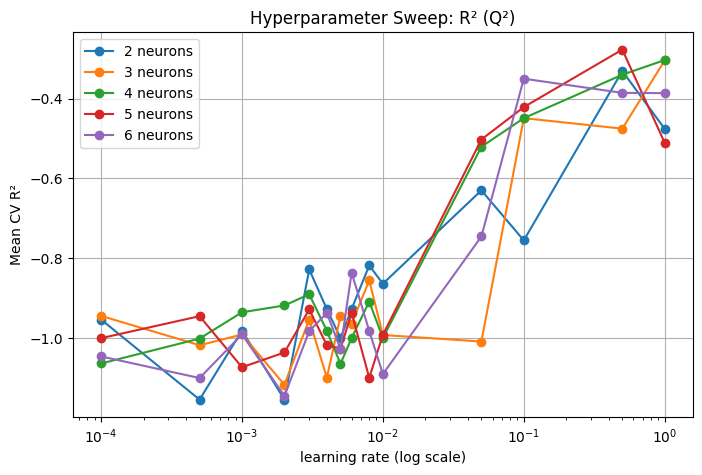

In [ ]:
# params values
learning_rates = [0.0001,0.0005,0.001,0.002,0.003,0.004,0.005,0.006,0.008,0.01,0.05,0.1,0.5,1.0] # Changed 1 to 1.0
neurons_list = [2, 3, 4, 5, 6]
n_folds = 5
n_epochs  = 400
momentum  = 0.5

results = []

kf = KFold(n_splits=n_folds, shuffle=True, random_state=85)

for lr in learning_rates:
    for n_neurons in neurons_list:
        aucs = []
        r2s  = []
        for train_idx, test_idx in kf.split(XTrainKnn):
            X_tr, X_val = XTrainKnn[train_idx], XTrainKnn[test_idx]
            y_tr, y_val = YTrain[train_idx], YTrain[test_idx]


            model = Sequential([
                Input(shape=(XTrainKnn.shape[1],)),
                Dense(n_neurons, activation='sigmoid'),  # n_neurons=6
                Dense(1, activation='sigmoid')
                ])

            # Compile the model before fitting
            optimizer = SGD(learning_rate=lr, momentum=momentum)
            model.compile(optimizer=optimizer, loss='binary_crossentropy')

            model.fit(X_tr, y_tr)

            # 预测 & 计算指标
            prob = model.predict(X_val).ravel() #  .ravel() flattens the output to a 1D array
            pred = (prob >= 0.5).astype(int) # predictions are based on a threshold of 0.5

            aucs.append(roc_auc_score(y_val, prob))
            r2s .append(r2_score(y_val, pred))

        results.append({
            'lr': lr,
            'neurons': n_neurons,
            'mean_auc': np.mean(aucs),
            'mean_r2':  np.mean(r2s)
        })

df = pd.DataFrame(results)

# plot: Learning Rate vs AUC
plt.figure(figsize=(8,5))
for n in neurons_list:
    sub = df[df['neurons']==n]
    plt.plot(sub['lr'], sub['mean_auc'], marker='o', label=f'{n} neurons')
plt.xscale('log')
plt.xlabel('learning rate (log scale)')
plt.ylabel('Mean CV AUC')
plt.title('Hyperparameter Sweep: AUC')
plt.legend()
plt.grid(True)
plt.show()

# plot R²(Q²)
plt.figure(figsize=(8,5))
for n in neurons_list:
    sub = df[df['neurons']==n]
    plt.plot(sub['lr'], sub['mean_r2'], marker='o', label=f'{n} neurons')
plt.xscale('log')
plt.xlabel('learning rate (log scale)')
plt.ylabel('Mean CV R²')
plt.title('Hyperparameter Sweep: R² (Q²)')
plt.legend()
plt.grid(True)
plt.show()

### 5. Build Model & Evaluate

In [ ]:
def evaluate_train_test(y_train, y_train_prob, y_train_pred,
                        y_test, y_test_prob, y_test_pred):
    from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Train/Test Metrics
    print("=== Train Evaluation ===")
    print("AUC:", roc_auc_score(y_train, y_train_prob))
    print("Accuracy:", accuracy_score(y_train, y_train_pred))
    print("Classification Report:\n", classification_report(y_train, y_train_pred))

    # Calculate Sensitivity and Specificity for Train
    tn, fp, fn, tp = confusion_matrix(y_train, y_train_pred).ravel()
    sensitivity_train = tp / (tp + fn)  # Recall
    specificity_train = tn / (tn + fp)
    print(f"Sensitivity (Recall): {sensitivity_train:.3f}")
    print(f"Specificity: {specificity_train:.3f}")

    print("\n=== Test Evaluation ===")
    print("AUC:", roc_auc_score(y_test, y_test_prob))
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print("Classification Report:\n", classification_report(y_test, y_test_pred))

    # Calculate Sensitivity and Specificity for Test
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
    sensitivity_test = tp / (tp + fn)  # Recall
    specificity_test = tn / (tn + fp)
    print(f"Sensitivity (Recall): {sensitivity_test:.3f}")
    print(f"Specificity: {specificity_test:.3f}")

    # Confusion Metrics
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    cm_train = confusion_matrix(y_train, y_train_pred)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axs[0])
    axs[0].set_title('Train Confusion Matrix')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('True')

    cm_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', ax=axs[1])
    axs[1].set_title('Test Confusion Matrix')
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('True')

    plt.tight_layout()
    plt.show()

    # ROC Curve
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_prob)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_prob)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {roc_auc_score(y_train, y_train_prob):.3f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {roc_auc_score(y_test, y_test_prob):.3f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_training_loss(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='Training Loss', color='orange')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
=== Train Evaluation ===
AUC: 1.0
Accuracy: 0.9977528089887641
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       221
         1.0       1.00      1.00      1.00       224

    accuracy                           1.00       445
   macro avg       1.00      1.00      1.00       445
weighted avg       1.00      1.00      1.00       445

Sensitivity (Recall): 0.996
Specificity: 1.000

=== Test Evaluation ===
AUC: 0.8009654062751408
Accuracy: 0.7309417040358744
Classification Report:
               precision    recall  f1-score   support

         0.0       0.73      0.73      0.73       110
         1.0       0.73      0.73      0.73       113

    accuracy                           0.73       223
   macro avg       0.73      0.73      0.73       223
weighted avg       0.73      0.73      0.73       223

Sensitivity (Recall): 0.735
Spec

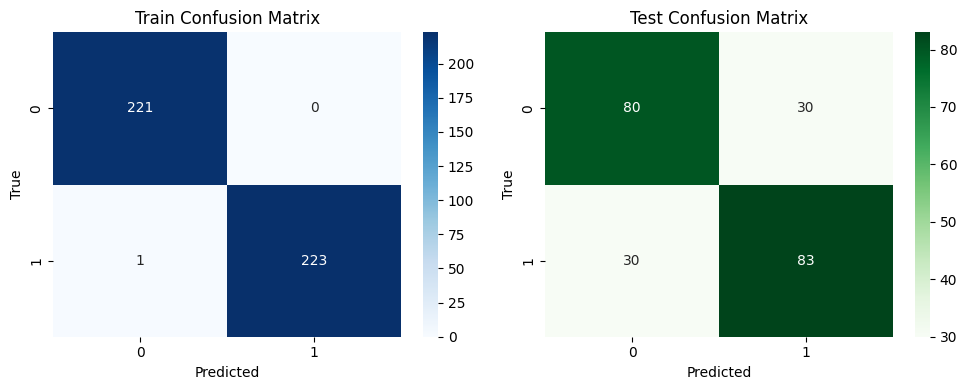

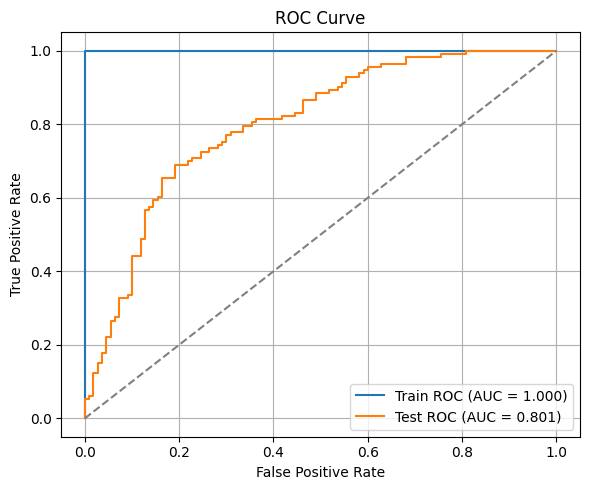

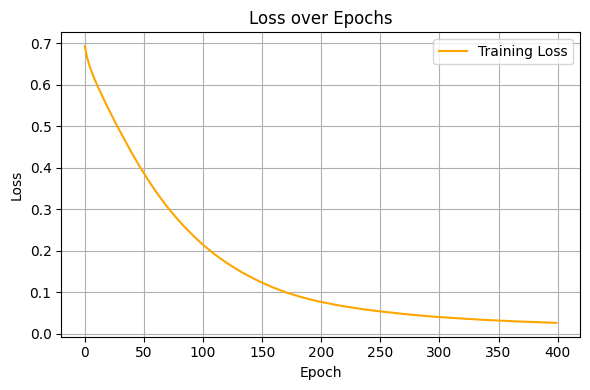

In [ ]:
best_n_neurons = 5
best_learning_rate = 0.01

# 1. construct ANN-SigSig
model = Sequential([
    Input(shape=(XTrainKnn.shape[1],)),
    Dense(best_n_neurons, activation='sigmoid'),  # n_neurons=6
    Dense(1, activation='sigmoid')
])
optimizer = SGD(learning_rate=best_learning_rate, momentum=0.5)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# 2. Training model

history = model.fit(XTrainKnn, YTrain, epochs=400, verbose=0)


# 3. Prediction
YPredTrainProb = model.predict(XTrainKnn).ravel()
YPredTestProb = model.predict(XTestKnn).ravel()
## Label
YPredTrain = (YPredTrainProb >= 0.7).astype(int)
YPredTest = (YPredTestProb >= 0.7).astype(int)


# 4. Evaluation
evaluate_train_test(YTrain, YPredTrainProb, YPredTrain,
           YTest, YPredTestProb, YPredTest)

plot_training_loss(history)
